**Group Members:**

 _ |Names | Student Number
---|---|---
1| Bongumusa Mavuso | 1682836
2| Thabo Rachidi | 1632496
3| Thobelani Makeleni | 1199116
4| Siyabonga Hlomuka | 1384685

## **Imports:**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_theme(style="white")

import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy import stats
import reverse_geocoder as rg
import pprint
import geopandas
import matplotlib.image as mpimg

from sklearn.cluster import DBSCAN

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import warnings
warnings.filterwarnings("ignore")

## **Reading Data:**

In [2]:
df = pd.read_csv('nyc_taxis.csv', delimiter=',', header=0, index_col=0)
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 122.4+ MB


## **Question 1.2:**

In [4]:
def haversine_dist(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    
    :params lon1: First point longitude in degrees
    :params lat1: First point latitude in degrees
    :params lon2: Second point longitude in degress
    :params lat2: Second point latitude in degrees
    
    :returns distance in kilometers
    """
    # Convert decimal degrees to radians 
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth(km)
    
    distance = c*r
    
    return np.round(distance,decimals=3)

In [5]:
df['trip_distance(km)'] = haversine_dist(df['pickup_longitude'], df['pickup_latitude'], 
              df['dropoff_longitude'], df['dropoff_latitude'])
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km)
id,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189


### **Create Average speed column:**

In [6]:
df['avg_speed(km/hr)'] = df['trip_distance(km)']/(df['trip_duration'].apply(lambda x: x/3600))
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr)
id,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,11.860220
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,9.806335
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,10.822034
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,12.461538
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,9.840000


### **Create date columns:**

In [7]:
# Year
df['trip_year'] = pd.to_datetime(df['pickup_datetime']).dt.year

# Month
df['trip_month'] = pd.to_datetime(df['pickup_datetime']).dt.month

# Day_of_week
df['trip_weekday'] = pd.to_datetime(df['pickup_datetime']).dt.weekday

df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr),trip_year,trip_month,trip_weekday
id,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,11.860220,2016,3,0
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,9.806335,2016,6,6
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,10.822034,2016,1,1
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,12.461538,2016,4,2
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,9.840000,2016,3,5


## **Question 1.1:**

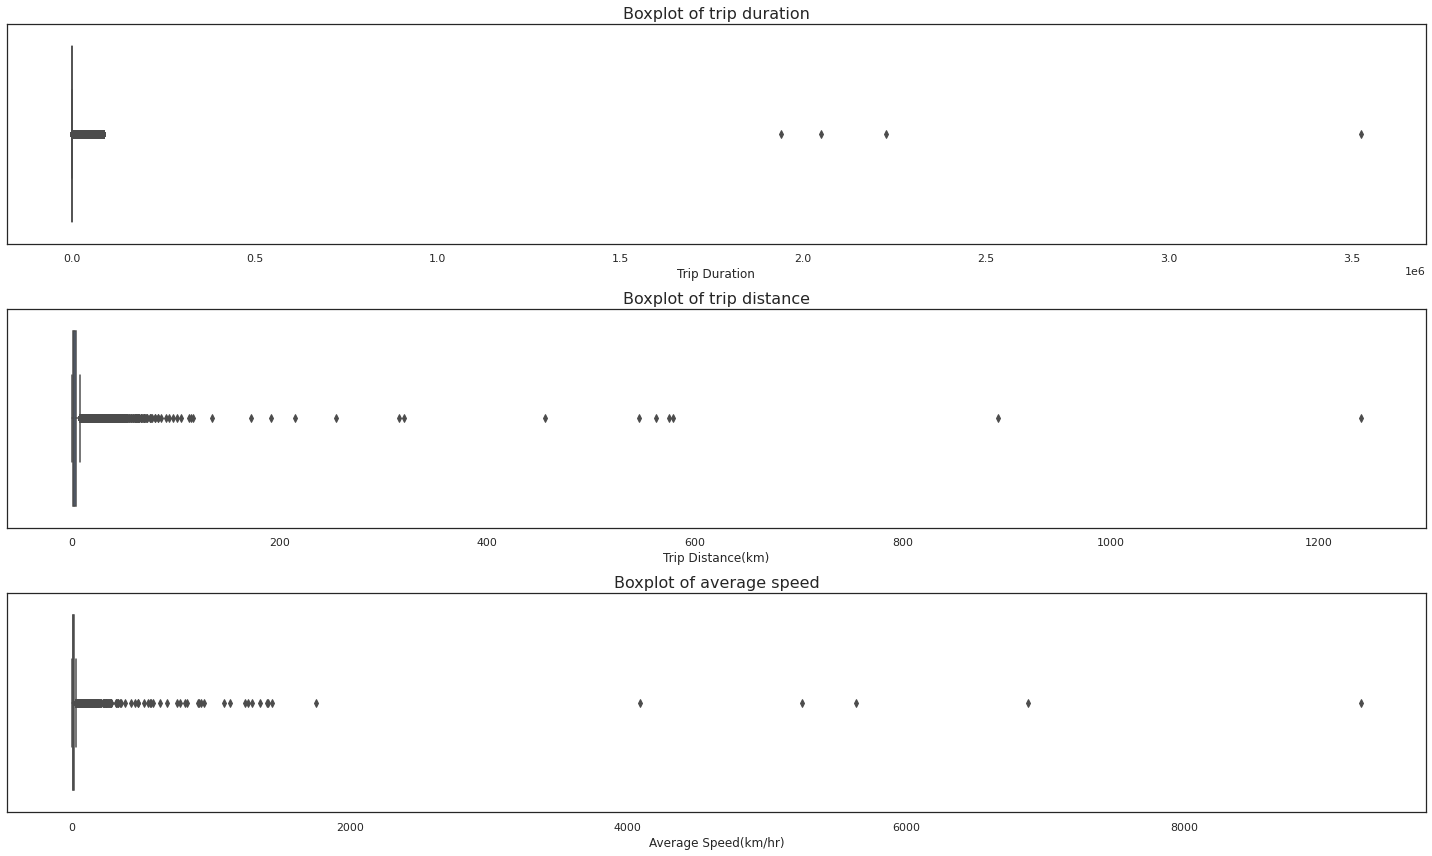

In [8]:
# Plots
fig, axes = plt.subplots(figsize=(20,12),nrows=3, ncols = 1)

sns.boxplot(x=df['trip_duration'], ax=axes[0])
axes[0].set_title('Boxplot of trip duration',fontsize=16)
axes[0].set_xlabel('Trip Duration')

sns.boxplot(x=df['trip_distance(km)'], ax=axes[1])
axes[1].set_title('Boxplot of trip distance',fontsize=16)
axes[1].set_xlabel('Trip Distance(km)')

sns.boxplot(x=df['avg_speed(km/hr)'], ax=axes[2])
axes[2].set_title('Boxplot of average speed',fontsize=16)
axes[2].set_xlabel('Average Speed(km/hr)')

plt.tight_layout()
plt.show()

**Inital observations:**

* From the plots above we can see that there clearly some outliers in the dataset.
* The trip duration plot: It looks like the outliers occur from around $2.0\times 10^{6}$seconds. This is roughly equal to 555 hours. This is not really possible.
* The trip distance plot: Some of the values from above 200km could be outliers but we can investigate further.
* The average speed plot could have values influenced by the outliers in the trip duration or trip distance.

### **1. Investigate trip duration:**

#### **Z-score:**

In [9]:
z_score_1 = np.abs(stats.zscore(df['trip_duration']))
thresh = 3

# position of the outlier
filtered_entries = (z_score_1 > 3)
outlier_1 = df[filtered_entries]
print('Outliers found',len(outlier_1))

Outliers found 2073


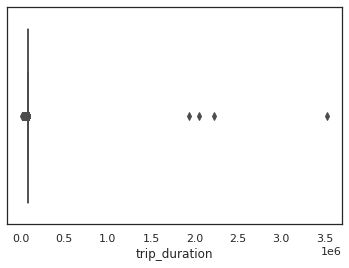

In [10]:
# View outliers
sns.boxplot(x=outlier_1['trip_duration'])
plt.show()

Here we can see that my inital assumption about some of the larger outliers was correct. What my inital observation missed was some the lower outliers that could occur.

### **2. Investigate trip distance:**

#### **Z-score:**

In [11]:
z_score_2 = np.abs(stats.zscore(df['trip_distance(km)']))
thresh = 3

# position of the outlier
filtered_entries = (z_score_2 > thresh)
outlier_2 = df[filtered_entries]
print('Outliers found',len(outlier_2))

Outliers found 40117


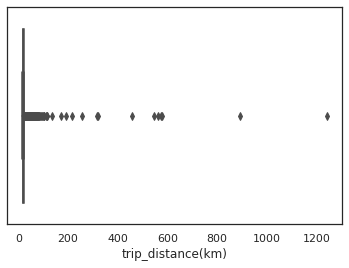

In [12]:
# View outliers
sns.boxplot(x=outlier_2['trip_distance(km)'])
plt.show()

We can see from the outliers above that my initial observation about the values from 200km was correct and that I may have also missed some values that are below 200km.

### **3. Investigate average speed:**

#### **Z-score**

In [13]:
z_score_3 = np.abs(stats.zscore(df['avg_speed(km/hr)']))
thresh = 3

# position of the outlier
filtered_entries = (z_score_3 > thresh)
outlier_3 = df[filtered_entries]
print('Outliers found',len(outlier_3))

Outliers found 734


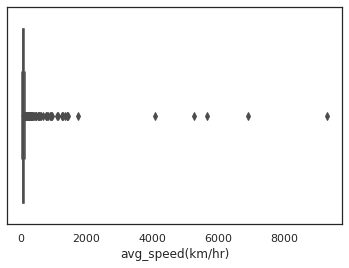

In [14]:
# View outliers
sns.boxplot(x=outlier_3['avg_speed(km/hr)'])
plt.show()

### **Dropping the outliers from the three feauture observations:**

In [15]:
# Drop the rows
outliers = outlier_1 + outlier_2 + outlier_3
df = df.drop(outliers.index)

### **Display Boxplots after outlier removal:**

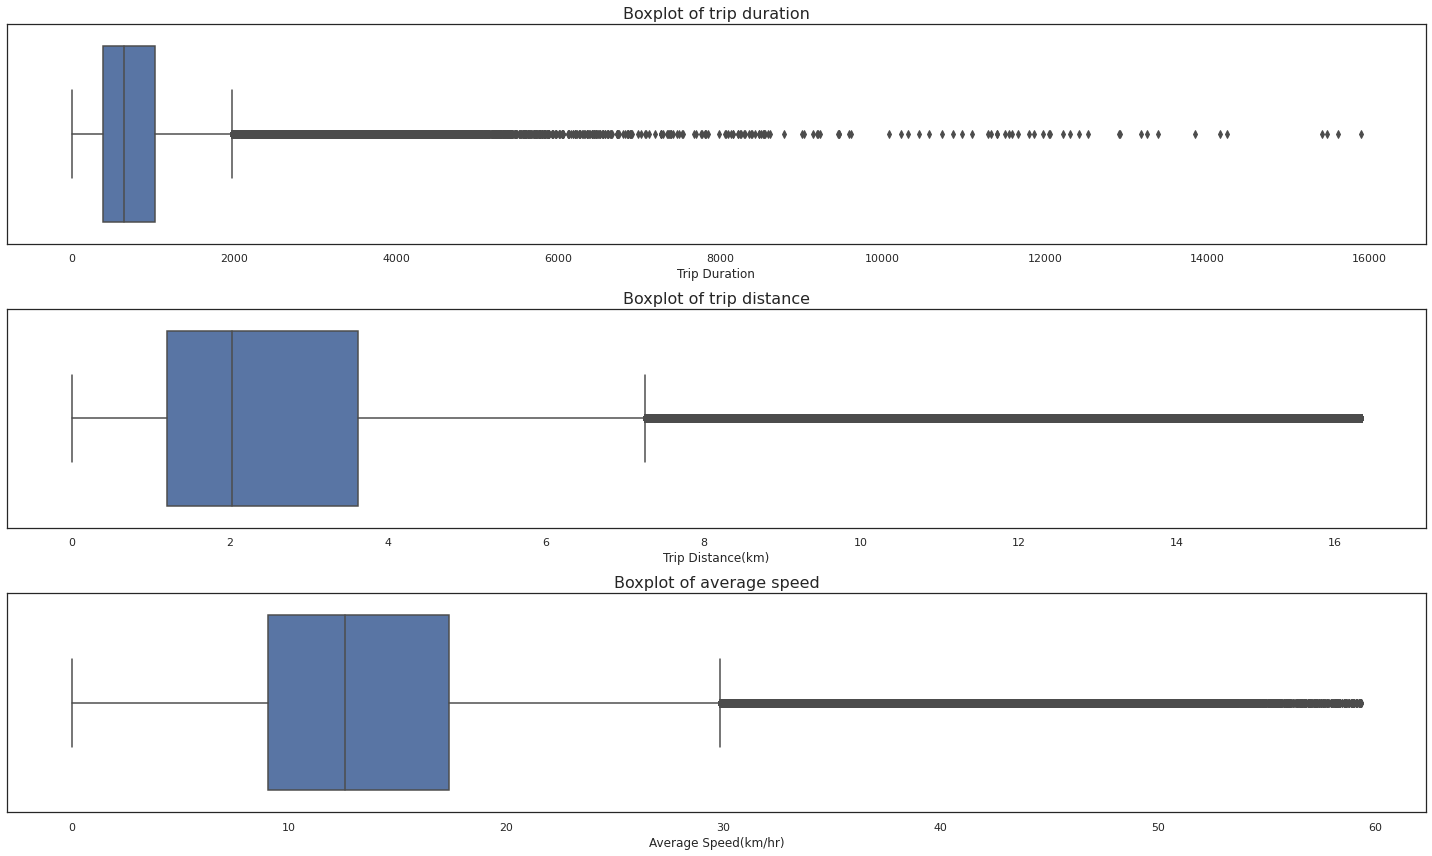

In [16]:
# Plots
fig, axes = plt.subplots(figsize=(20,12),nrows=3, ncols = 1)

sns.boxplot(x=df['trip_duration'], ax=axes[0])
axes[0].set_title('Boxplot of trip duration',fontsize=16)
axes[0].set_xlabel('Trip Duration')

sns.boxplot(x=df['trip_distance(km)'], ax=axes[1])
axes[1].set_title('Boxplot of trip distance',fontsize=16)
axes[1].set_xlabel('Trip Distance(km)')

sns.boxplot(x=df['avg_speed(km/hr)'], ax=axes[2])
axes[2].set_title('Boxplot of average speed',fontsize=16)
axes[2].set_xlabel('Average Speed(km/hr)')

plt.tight_layout()
plt.show()

## **Qusetion 1.3:**

#### **Question 1.3.1:**

In [17]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

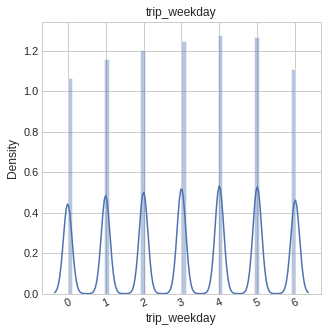

In [18]:
plot_distribution(df[['trip_weekday']], cols=3, width=20, height=5, hspace=0.5, wspace=0.5)

In [19]:
df['trip_weekday'].value_counts().idxmax()

4

#### **Question 1.3.2:**

In [20]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df['trip_hour'] = df['pickup_datetime'].dt.hour
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr),trip_year,trip_month,trip_weekday,trip_hour
id,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,11.860220,2016,3,0,17
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,9.806335,2016,6,6,0
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,10.822034,2016,1,1,11
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,12.461538,2016,4,2,19
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,9.840000,2016,3,5,13


In [21]:
peak_hour_of_day = df.groupby('trip_weekday').agg({'trip_hour':pd.Series.mode})
peak_hour_of_day

,trip_hour
trip_weekday,
0,18
1,18
2,19
3,21
4,19
5,23
6,0


On a Monday most people pickup at 6pm <br>
On a Tuesday most people pickup at 6pm <br>
On a Wednesday most people pickup at 7pm <br>
On a Thursday most people pickup at 9pm <br>
On a Friday most people pickup at 7pm <br>
On a Saturday most people pickup at 11pm <br>
On a Sunday most people pickup at 12am

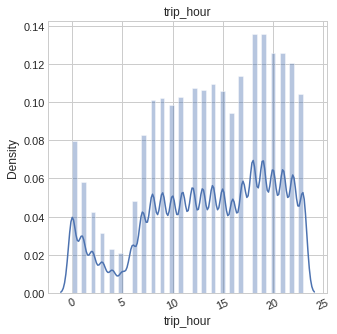

In [22]:
plot_distribution(df[['trip_hour']], cols=3, width=20, height=5, hspace=0.5, wspace=0.5)

Most people pickup at 6pm and 7pm <br>
This can be due to most people are coming back from work at that time

#### **Question 1.3.3**

In [23]:
hours_in_day = df.groupby('trip_weekday')['trip_hour'].apply(list)

##### **Weekdays:**

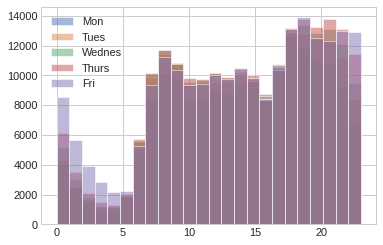

In [24]:
plt.hist(hours_in_day[0], 24,label='Mon',alpha = 0.5)
plt.hist(hours_in_day[1], 24,label='Tues',alpha = 0.5)
plt.hist(hours_in_day[2], 24,label='Wednes',alpha = 0.5)
plt.hist(hours_in_day[3], 24,label='Thurs',alpha = 0.5)
plt.hist(hours_in_day[4], 24,label='Fri',alpha = 0.5)
plt.legend()
plt.show()

##### **Weekends:**

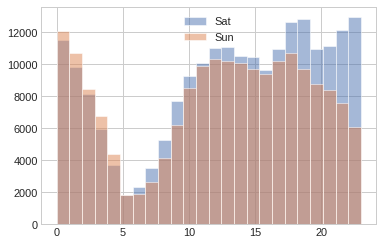

In [25]:
plt.hist(hours_in_day[5], 24,label='Sat',alpha = 0.5)
plt.hist(hours_in_day[6], 24,label='Sun',alpha = 0.5)
plt.legend()
plt.show()

##### **Weekday VS Weekend:**

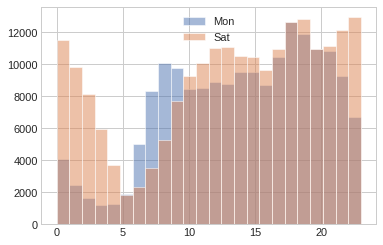

In [26]:
plt.hist(hours_in_day[0], 24,label='Mon',alpha = 0.5)
plt.hist(hours_in_day[5], 24,label='Sat',alpha = 0.5)
plt.legend()
plt.show()

On weekends most people like to pickup at early Morning 12am to 5am. <br>
Saturday is similar to weekdays but there are more pickups in the early hours 12am to 5am <br>
On Sunday after 6pm most people don't pickup anymore. <br>
The early pickups on weekend might be due to people traveling to vist there families, it can also be due to people partying on the weekend. <br>
We can also see that not much pickups happen at 5am to 10am at the weekends, this can be due to people not going to work.

#### **Question 1.3.4:**

In [27]:
cal = calendar()
Holidays = cal.holidays(start=df['pickup_datetime'].min(), end=df['pickup_datetime'].max())
df['Holiday'] = df['pickup_datetime'].dt.date.astype('datetime64').isin(Holidays)
Holidays

DatetimeIndex(['2016-01-18', '2016-02-15', '2016-05-30'], dtype='datetime64[ns]', freq=None)

In [28]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr),trip_year,trip_month,trip_weekday,trip_hour,Holiday
id,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.499,11.860220,2016,3,0,17,False
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806,9.806335,2016,6,6,0,False
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385,10.822034,2016,1,1,11,False
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485,12.461538,2016,4,2,19,False
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.189,9.840000,2016,3,5,13,False


In [29]:
Holidays_df = df[df['Holiday'] == True]
Holidays_df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance(km),avg_speed(km/hr),trip_year,trip_month,trip_weekday,trip_hour,Holiday
id,,,,,,,,,,,,,,,,,
id0675800,2,2016-02-15 09:25:15,2016-02-15 09:35:49,6,-73.977753,40.754631,-74.001678,40.756420,N,634,2.025,11.498423,2016,2,0,9,True
id2648478,1,2016-01-18 11:13:59,2016-01-18 11:18:56,1,-73.951576,40.766468,-73.960213,40.760540,N,297,0.982,11.903030,2016,1,0,11,True
id1674373,2,2016-02-15 17:52:27,2016-02-15 18:02:13,5,-74.007500,40.740952,-74.016647,40.704910,N,586,4.081,25.070990,2016,2,0,17,True
id2677357,2,2016-02-15 16:36:19,2016-02-15 16:41:50,2,-73.971634,40.781963,-73.981689,40.778996,N,331,0.909,9.886405,2016,2,0,16,True
id3013319,2,2016-02-15 22:28:54,2016-02-15 22:30:27,1,-73.981400,40.778793,-73.976524,40.782497,N,93,0.581,22.490323,2016,2,0,22,True


In [30]:
hours_in_day_holidays = Holidays_df.groupby('trip_weekday')['trip_hour'].apply(list)

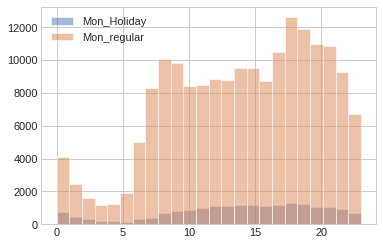

In [31]:
plt.hist(hours_in_day_holidays[0], 24,label='Mon_Holiday',alpha = 0.5)
plt.hist(hours_in_day[0], 24,label='Mon_regular',alpha = 0.5)
plt.legend()
plt.show()

Compared to a noraml Monday, the one on Holiday indicate that they are far less pickups then normal. <br>
This shows that most people don't work or travel on Holidays

#### **Question 1.3.5:**

In [32]:
day_speed = df[['pickup_datetime','avg_speed(km/hr)']]
day_speed.head()

,pickup_datetime,avg_speed(km/hr)
id,,
id2875421,2016-03-14 17:24:55,11.860220
id2377394,2016-06-12 00:43:35,9.806335
id3858529,2016-01-19 11:35:24,10.822034
id3504673,2016-04-06 19:32:31,12.461538
id2181028,2016-03-26 13:30:55,9.840000


In [33]:
day_speed_df = day_speed.groupby(pd.Grouper(key='pickup_datetime', freq='60min')).mean().dropna()
day_speed_df.head()

,avg_speed(km/hr)
pickup_datetime,
2016-01-01 00:00:00,15.019020
2016-01-01 01:00:00,14.912572
2016-01-01 02:00:00,16.311287
2016-01-01 03:00:00,16.999992
2016-01-01 04:00:00,17.716125


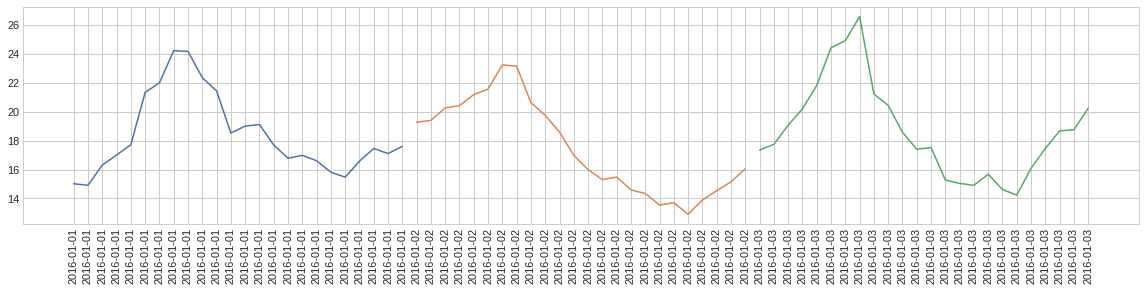

In [34]:
plt.figure(figsize=(20, 4))
plt.plot(day_speed_df.index[:24],day_speed_df.values[:24])
plt.plot(day_speed_df.index[24:48],day_speed_df.values[24:48])
plt.plot(day_speed_df.index[48:72],day_speed_df.values[48:72])
plt.xticks(rotation=90)
plt.xticks(day_speed_df.index[:72])
plt.show()

From the graphs it is seen that at around 5am to 8am the highest average speeds are archieved around 22km/hr to 27km/hr. This can be caused by people rushing to work. <br>
The slowest speeds are around 5pm to 8pm. This is when the taxis travel the slowest below 14km/hr. This can be due to traffic when everyone is returning from work and because people are not necessary in a rush when returning from work.

## **Question 1.5:**

In [35]:
data = pd.read_csv('nyc_taxis.csv', delimiter=',', header=0, index_col=0)
data.head(5)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [36]:
pickup_datetime_update = data['pickup_datetime'].astype('datetime64[ns]')
dropoff_datetime_update = data['dropoff_datetime'].astype('datetime64[ns]')
data['pickup_datetime'] = pickup_datetime_update
data['dropoff_datetime'] = dropoff_datetime_update
pickup_time = data['pickup_datetime'][0]
dropoff_time = data['dropoff_datetime'][0]

def to_seconds(duration):
    return duration.total_seconds()

travel_time =  data['dropoff_datetime'].sub(data['pickup_datetime'], axis = 0)

data['travel_time'] = travel_time

data['travel_time'] = data['travel_time'].apply(to_seconds)

data.head(5)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,travel_time
id,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,455.0
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,663.0
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2124.0
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,429.0
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,435.0


In [37]:
import reverse_geocoder as rg
import pprint

def reverseGeocode(coordinates):
    result = rg.search(coordinates)
     
    # result is a list containing ordered dictionary.
    pprint.pprint(result)

In [38]:
# coordinates for Empire State Building
reverseGeocode((40.748541, -73.985758))

Loading formatted geocoded file...
[{'admin1': 'New York',
  'admin2': 'Queens County',
  'cc': 'US',
  'lat': '40.74482',
  'lon': '-73.94875',
  'name': 'Long Island City'}]


In [39]:
# coordinates for JFK AIRPORT
reverseGeocode((40.647352,  -73.790534))

[{'admin1': 'New York',
  'admin2': 'Queens County',
  'cc': 'US',
  'lat': '40.69149',
  'lon': '-73.80569',
  'name': 'Jamaica'}]


In [40]:
# coordinates for NEWARK LIBERTY AIRPORT
reverseGeocode((40.704197,  -74.190124))

[{'admin1': 'New Jersey',
  'admin2': 'Essex County',
  'cc': 'US',
  'lat': '40.73566',
  'lon': '-74.17237',
  'name': 'Newark'}]


In [41]:
data_JFK = data[abs(data['pickup_latitude'] -  40.748541) <= 0.009999]
data_JFK = data_JFK[abs(data_JFK['pickup_longitude'] + 73.985758) <= 0.009999]
data_JFK = data_JFK[abs(data_JFK['dropoff_latitude'] - 40.647352) <= 0.009999]
data_JFK = data_JFK[abs(data_JFK['dropoff_longitude'] + 73.790534) <= 0.009999]

data_JFK.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,travel_time
id,,,,,,,,,,,
id3930440,1,2016-06-01 14:29:00,2016-06-01 15:44:28,1,-73.987869,40.748219,-73.783760,40.643600,N,4528,4528.0
id1365474,1,2016-04-26 16:24:10,2016-04-26 17:24:13,1,-73.992050,40.751514,-73.790039,40.646957,N,3603,3603.0
id3401826,1,2016-04-27 10:20:02,2016-04-27 11:01:32,2,-73.992538,40.756557,-73.789757,40.643002,N,2490,2490.0
id1909463,1,2016-03-27 10:13:49,2016-03-27 10:41:50,2,-73.990303,40.756023,-73.788696,40.647415,N,1681,1681.0
id3861834,1,2016-05-09 16:24:51,2016-05-09 17:29:44,2,-73.978928,40.745937,-73.790367,40.646748,N,3893,3893.0


In [42]:
times = pd.DatetimeIndex(data_JFK.pickup_datetime)
grouped_by_hour = data_JFK.groupby([times.hour]).mean()/(60*60)
average_trip_time = list(grouped_by_hour['trip_duration'])
pickup_hours = list(range(0, 24))

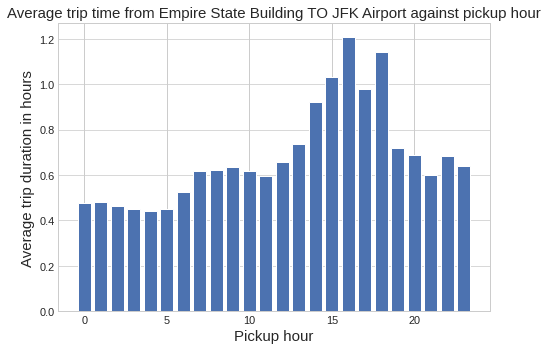

In [43]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pickup_hours, average_trip_time)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pickup hour',fontsize=15)
plt.ylabel('Average trip duration in hours',fontsize=15)
plt.title('Average trip time from Empire State Building TO JFK Airport against pickup hour',fontsize=15)
plt.show()

In [44]:
data_Newark = data[abs(data['pickup_latitude'] -  40.748541) <= 0.009999]
data_Newark = data_Newark[abs(data_Newark['pickup_longitude'] + 73.985758) <= 0.009999]
data_Newark = data_Newark[abs(data_Newark['dropoff_latitude'] - 40.704197) <= 0.009999]
data_Newark = data_Newark[abs(data_Newark['dropoff_longitude'] + 74.190124) <= 0.009999]

data_Newark

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,travel_time
id,,,,,,,,,,,
id1938148,1,2016-05-05 05:04:30,2016-05-05 05:30:56,4,-73.987572,40.755486,-74.185478,40.694221,N,1586,1586.0
id0922516,1,2016-04-14 17:42:41,2016-04-14 18:32:34,2,-73.985268,40.741959,-74.188423,40.695454,N,2993,2993.0
id1024232,2,2016-05-29 13:22:50,2016-05-29 14:01:47,1,-73.984085,40.746181,-74.180962,40.695114,N,2337,2337.0
id2930052,2,2016-03-26 13:28:12,2016-03-26 14:01:03,1,-73.976532,40.752068,-74.183891,40.700661,N,1971,1971.0
id3302698,1,2016-02-07 20:44:28,2016-02-07 21:09:56,1,-73.995567,40.750332,-74.184097,40.696411,N,1528,1528.0
id3774443,2,2016-03-24 02:49:53,2016-03-24 03:14:40,1,-73.992813,40.748081,-74.186218,40.697731,N,1487,1487.0
id0018553,1,2016-03-09 05:03:15,2016-03-09 05:23:31,2,-73.992096,40.748821,-74.187927,40.696171,N,1216,1216.0
id1831880,1,2016-03-20 13:57:33,2016-03-20 14:26:04,1,-73.982964,40.757057,-74.181496,40.705097,N,1711,1711.0
id0503169,2,2016-01-19 12:09:52,2016-01-19 12:46:29,1,-73.977722,40.754810,-74.181709,40.694752,N,2197,2197.0


In [45]:
times = pd.DatetimeIndex(data_Newark.pickup_datetime)
grouped_by_hour = data_Newark.groupby([times.hour]).mean()/(60*60)
average_trip_time_Newark = list(grouped_by_hour['trip_duration'])
pickup_hours_Newark = list(grouped_by_hour.index)

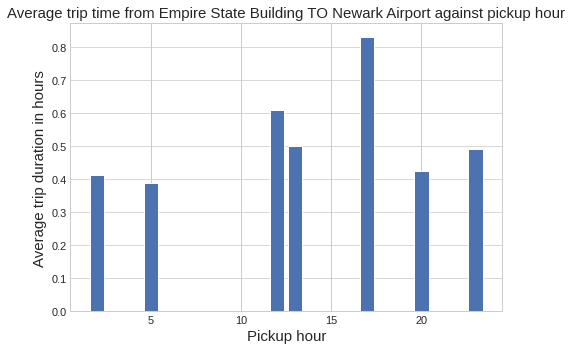

In [46]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pickup_hours_Newark, average_trip_time_Newark)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Pickup hour',fontsize=15)
plt.ylabel('Average trip duration in hours',fontsize=15)
plt.title('Average trip time from Empire State Building TO Newark Airport against pickup hour',fontsize=15)
plt.show()

### **Comments:**

The major difference is that there are always trips from Empire State Building to JFK Airport every hour. Whereas, this is not the case from Empire State Building to Newark Airport since some of the averages trip times in the second graph are zeros for several pickup hours. 

## **Question 1.6:**

### **Number of passengers:** 

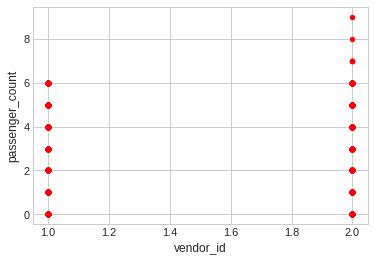

In [47]:
data  = data.reset_index()
data.plot.scatter(x='vendor_id',y='passenger_count',color = 'red', colormap='viridis')
plt.show()

### **Duration of trips:**

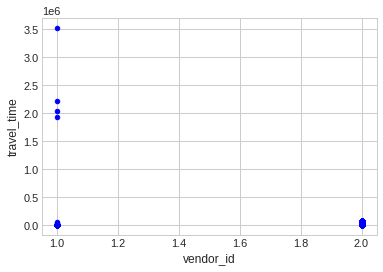

In [48]:
data.plot.scatter(x='vendor_id',y='travel_time',color = 'blue',  colormap='viridis')
plt.show()

### **Pickup locations:**

In [49]:
pickup_data = data[['vendor_id', 'pickup_latitude', 'pickup_longitude']]
gdf_pickup = geopandas.GeoDataFrame(pickup_data, geometry=geopandas.points_from_xy(data.pickup_latitude, data.pickup_longitude))

gdf_pickup.head()

,vendor_id,pickup_latitude,pickup_longitude,geometry
0,2,40.767937,-73.982155,POINT (40.76794 -73.98215)
1,1,40.738564,-73.980415,POINT (40.73856 -73.98042)
2,2,40.763939,-73.979027,POINT (40.76394 -73.97903)
3,2,40.719971,-74.010040,POINT (40.71997 -74.01004)
4,2,40.793209,-73.973053,POINT (40.79321 -73.97305)


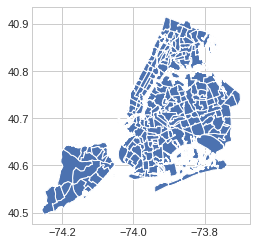

In [50]:
nyc_map = geopandas.read_file('geo_export_b0262261-5940-4b03-b89d-d4eb921ae481.dbf')
nyc_map.to_crs(epsg=4326).plot()
plt.show()

<Figure size 1080x1080 with 0 Axes>

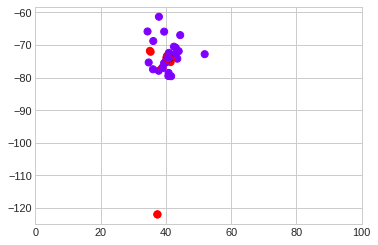

In [59]:
plt.figure(figsize = (15,15))
gdf_pickup.plot(column = 'vendor_id', cmap = 'rainbow', markersize = 50)
ax.set_title('New York City Pickup Locations')
plt.xlim([0, 100])
plt.show()

### **Dropoff locations:**

In [52]:
dropoff_data = data[['vendor_id', 'dropoff_latitude', 'dropoff_longitude']]
gdf_dropoff = geopandas.GeoDataFrame(dropoff_data, geometry=geopandas.points_from_xy(data.dropoff_latitude, data.dropoff_longitude))

gdf_dropoff.head()

,vendor_id,dropoff_latitude,dropoff_longitude,geometry
0,2,40.765602,-73.964630,POINT (40.76560 -73.96463)
1,1,40.731152,-73.999481,POINT (40.73115 -73.99948)
2,2,40.710087,-74.005333,POINT (40.71009 -74.00533)
3,2,40.706718,-74.012268,POINT (40.70672 -74.01227)
4,2,40.782520,-73.972923,POINT (40.78252 -73.97292)


<Figure size 1080x1080 with 0 Axes>

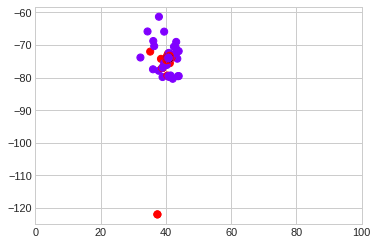

In [60]:
plt.figure(figsize = (15,15))
gdf_dropoff.plot(column = 'vendor_id' , cmap = 'rainbow', markersize = 50)
ax.set_title('New York City Dropoff Locations')
plt.xlim([0, 100])
plt.show()

#### **Comments:**

It is evident from the plots above that the vendor with a vendor_id 1 is Yellow Cabs and the vendor with a vendor_id 2 is boro taxi. We came to this conclusion since we know that Yellow Cabs operates all over New york city and Boro taxis operates within restricted areas. So, Yellow Cabs are expected to have more average travel duration than boro taxis and Yellow Cabs are expected to have more pickup locations and dropoff locations spread out New York City compared to Boros. Also, Yellow Cabs are expected to have at most 6 passengers whereas for Boros this number can be greater. These expectations were all visible from the plots.

## **Question 1.4:**

### **Weekdays:**

#### **Mornings:**

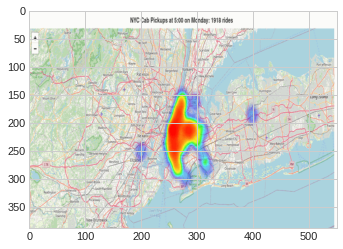

In [61]:
image1 = mpimg.imread('pickup_weekday_morning.gif')
imgplot = plt.imshow(image1)
plt.show()

#### **Afternoons:**

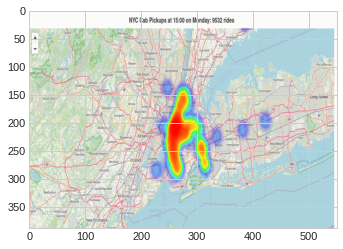

In [62]:
image2 = mpimg.imread('pickup_weekday_afternoon.gif')
imgplot = plt.imshow(image2)
plt.show()

### **Weekends:**

#### **Mornings:**

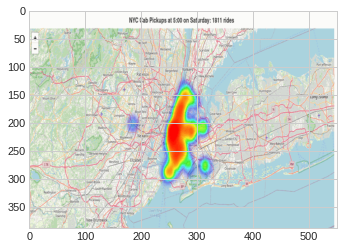

In [63]:
image3 = mpimg.imread('pickup_weekend_morning.gif')
imgplot = plt.imshow(image3)
plt.show()

#### **Afternoons:**

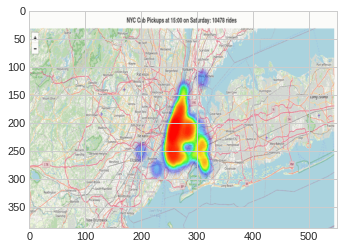

In [64]:
image4 = mpimg.imread('pickup_weekend_afternoon.gif')
imgplot = plt.imshow(image4)
plt.show()

### **Comments:**

There are a lot of trips taken in the mornings of weekdays compared to the trips taken in the afternoons of weekdays.Also, there a lot of trips taken in the afternoons of weekends compared to trips taken in the mornings of weekends. In the morning of weekdays normally people are rushing to work or school so this explains the high volume of trips during these hours, whereas in the afternoon are people may opt to walk to their places. During weekends in the morning most people are usually in doors, so they make less trips. In the afternnons of weekends, people may come back late from events and parties and hence may need transport to go back home so this explains the huge volume of trips during this time.

In [ ]:
dbscan_pick = DBSCAN(eps=0.01, min_samples=15, algorithm='ball_tree', metric='haversine').fit(np.radians(data.loc[:,'pickup_longitude':'pickup_latitude'].fillna(0,inplace=False)))
labels_pick = dbscan_pick.labels_

In [ ]:
len(np.unique(labels_pick))

Number of clusters we got  = 2